In [55]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot
from rasterio.merge import merge


## Combine band -> NDVI 

In [64]:
datasetName = 'LC08_L1TP_127051_20180114_20180120_01_T1'
listFile = ['Data/' + datasetName + '/' + datasetName + '_B5.TIF',
           'Data/' + datasetName + '/' + datasetName + '_B4.TIF',
           'Data/' + datasetName + '/' + datasetName + '_B3.TIF']
with rasterio.open(listFile[0]) as src:
    meta = src.meta

meta.update(count = len(listFile))

with rasterio.open('NDVI_Combined/201801_1.TIF','w', **meta) as des:
    for id, layer in enumerate(listFile):
        with rasterio.open(layer) as src:
            des.write_band(id + 1, src.read(1))

/home/ahldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


## Merge GeoTIFF Data

In [92]:

monthYearLabel = '201801'
datasets = ['NDVI_Combined/' + monthYearLabel + '_1.TIF',
           'NDVI_Combined/' + monthYearLabel + '_2.TIF']

listFile = [rasterio.open(f) for f in datasets]

dest, output_transform = merge(listFile)

profile = listFile[0].profile
profile['transform'] = output_transform
profile['height'] = dest.shape[1]
profile['width'] = dest.shape[2]
# profile['driver'] = drive

# profile.update(**creation_options)

with rasterio.open('NDVI/' + monthYearLabel + '.TIF', 'w', **profile) as dst:
    dst.write(dest)
    
    try:
        colormap = listFile[0].colormap(1)
        dst.write_colormap(1, colormap)
    except ValueError:
        pass

## Calculate NDVI (old)

In [55]:


geoTiffData = rasterio.open('NDVI/201612.TIF')

bands = geoTiffData.read()
nir = bands[0]
red = bands[1]

ndvi = np.zeros(red.shape, dtype=rasterio.float32)
    # print(nir)
ndvi = (nir.astype(float)-red.astype(float))/(nir+red).astype(float)
# kwargs = geoTiffData.meta
# kwargs.update(
#     dtype=rasterio.float32,
#     count=1)

# with rasterio.open('example-total.tif', 'w', **kwargs) as dst:
#     dst.write_band(1, ndvi.astype(rasterio.float32))


/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [ ]:
from rasterio.tools.mask import mask
from rasterio.merge import merge

bands = geoTiffData.read()
pyplot.imshow(ndvi)
pyplot.imshow(bands[1])

In [ ]:
ndvi_score = np.zeros(geoTiffData.shape, dtype=rasterio.float32)
pyplot.imshow(bands[2])

In [57]:
kwargs = geoTiffData.meta
kwargs

{'affine': Affine(30.0, 0.0, 227385.0,
       0.0, -30.0, 1555215.0),
 'count': 3,
 'crs': CRS({'init': 'epsg:32648'}),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7781,
 'nodata': None,
 'transform': (227385.0, 30.0, 0.0, 1555215.0, 0.0, -30.0),
 'width': 13201}

In [27]:
with rasterio.open('example-total.tif', 'w', **kwargs) as dst:
    dst.write_band(1, ndvi_score.astype(rasterio.float32))

/home/ahldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


## Calculate NDVI by original Data

In [58]:
datasetName = 'LC08_L1TP_127051_20180114_20180120_01_T1'
listFile = ['Data/' + datasetName + '/' + datasetName + '_B6.TIF',
            'Data/' + datasetName + '/' + datasetName + '_B5.TIF',
           'Data/' + datasetName + '/' + datasetName + '_B4.TIF',
           'Data/' + datasetName + '/' + datasetName + '_B3.TIF']
bandMIR, bandNIR, bandRed, bandGreen = (rasterio.open(f) for f in listFile)

bandMIR = bandMIR.read()[0]
bandNIR = bandNIR.read()[0]
bandRed = bandRed.read()[0]
bandGreen = bandGreen.read()[0]

NDVI = np.zeros(rasterio.open(listFile[0]).shape, dtype=rasterio.float32)
MNDWI = np.zeros(rasterio.open(listFile[0]).shape, dtype=rasterio.float32)

In [ ]:
import math
_NDVI = np.zeros(rasterio.open(listFile[0]).shape, dtype=rasterio.float32)

for i in range(NDVI.shape[0]):
    for j in range(NDVI.shape[1]):
        nir = bandNIR[i,j].astype(float)
        red = bandRed[i,j].astype(float)
        green = bandGreen[i,j].astype(float)
        mir = bandMIR[i,j].astype(float)
        NDVI[i,j] = (nir - red) / (nir + red)
        if math.isnan(NDVI[i,j]):
           NDVI[i,j] = 1
        MNDWI[i,j] = (green - mir) / (green + mir)
        if math.isnan(MNDWI[i,j]):
           MNDWI[i,j] = 1

/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/ahldt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


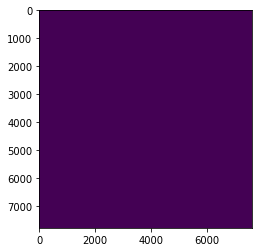

In [59]:
pyplot.imshow(NDVI)

In [ ]:
pyplot.imshow(MNDWI)

In [ ]:
Writing NDVI/MNDWI -> File

In [57]:
kwargs = rasterio.open(listFile[0]).meta
kwargs.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw')
with rasterio.open('example-total.tif', 'w', **kwargs) as dst:
    dst.write_band(1, NDVI.astype(rasterio.float32))

/home/ahldt/.local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
